In [1]:
import Pkg; Pkg.add("Tables")

    Updating registry at `C:\Users\Federico\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Federico\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Federico\.julia\environments\v1.7\Manifest.toml`


In [50]:
using GLM
import GLM: linkinv
using DataFrames
using Random
using Parquet
import YAML
using Term: install_term_logger, install_term_repr, install_term_stacktrace
using Plots
using CSV
using StatsBase

install_term_stacktrace()
install_term_repr()
install_term_logger()

base_folder = raw"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\GLM"
metadata = YAML.load_file(joinpath(base_folder, "metadata.yaml"))

@info "Loaded $(length(metadata)) metadata entries"

@Info (Main):  Loaded 113 metadata entries 
  ╰──────────────────────────────────────────────── 
                      Thu, 16 Jun 2022 11:12:19 


In [3]:
doing = collect(values(metadata))[14]
@assert doing["glm_fitted"]
# key = doing["recording"] * "_$(doing["unit"])"

## Define formulas

TODO: avoid repeating this code

In [4]:
Y = Term(:p_spike)
variables = Term.([
    :v, :v_squared, :dv_250ms, :dv_500ms, :dv_1000ms, :omega, :omega_squared, :domega_250ms, :domega_500ms, :domega_1000ms, :curv_0cm, :curv_10cm, :curv_20cm, :curv_30cm
])

# have a formula missing each individual predictor
formulas = Dict{String, Any}(
    "missing_$(variables[i])" => (Y ~ sum(variables[1:end .!= i])) for i = 1:length(variables)
)

# have a complete formula
formulas["complete"] = Y  ~ sum(variables)

# have a formula missing each class of predictors
formulas["missing_speed_class"] = @formula(p_spike ~ omega + omega_squared + domega_250ms + domega_500ms + domega_1000ms + curv_0cm + curv_10cm + curv_20cm + curv_30cm)
formulas["missing_curv_class"] = @formula(p_spike ~ v + v_squared + dv_250ms + dv_500ms + dv_1000ms + omega + omega_squared + domega_250ms + domega_500ms + domega_1000ms)
formulas["missing_omega_class"] = @formula(p_spike ~ v + v_squared + dv_250ms + dv_500ms + dv_1000ms + curv_0cm + curv_10cm + curv_20cm + curv_30cm)
formulas

╭──── Dict {String, Any}  ────────────────────────────────────────────────────╮
│                                                                             │
│   {String} │   missing_dv_500ms    => p_spike ~ v + v_squared + ... ...     │
│   {String} │ missing_domega_500ms  => p_spike ~ v + v_squared + ... ...     │
│   {String} │   missing_curv_0cm    => p_spike ~ v + v_squared + ... ...     │
│   {String} │  missing_curv_class   => p_spike ~ v + v_squared + ... ...     │
│   {String} │ missing_domega_1000ms => p_spike ~ v + v_squared + ... ...     │
│   {String} │ missing_domega_250ms  => p_spike ~ v + v_squared + ... ...     │
│   {String} │   missing_curv_20cm   => p_spike ~ v + v_squared + ... ...     │
│   {String} │   missing_v_squared   => p_spike ~ v + dv_250ms + ...  ...     │
│   {String} │   missing_dv_1000ms   => p_spike ~ v + v_squared + ... ...     │
│   {String} │   missing_curv_30cm   => p_spike ~ v + v_squared + ... ...     │
│      ⋮     │           ⋮              

## Load the best model
Load it's coefficients and the formula

In [31]:
best = doing["best_formula"]
best_fold = doing["best_fold"] - 1

# load coefficients
unit_folder = splitdir(doing["unit_data"])[1]
coefficients = DataFrame(CSV.File(joinpath(
    unit_folder, "coefficients", "$(best)_$(best_fold).csv"
)))
β = coefficients[:, "Coef."]

F = formulas[best]

coefficients

,Name,Coef.,Std. Error,z,Pr(>|z|),Lower 95%,Upper 95%
,String15,Float64,Float64,Float64,Float64,Float64,Float64
1,(Intercept),-5.9794,0.141599,-42.2276,0.0,-6.25693,-5.70187
2,v,1111.53,205.171,5.41761,6.04025e-8,709.407,1513.66
3,v_squared,-868.018,139.162,-6.23748,4.44671e-10,-1140.77,-595.266
4,dv_250ms,-9.44101,19.44,-0.485648,0.627217,-47.5428,28.6608
5,dv_1000ms,44.6698,23.1553,1.92914,0.0537136,-0.713759,90.0534
6,omega,-80.9618,25.9048,-3.12536,0.00177589,-131.734,-30.1893
7,omega_squared,19.4007,20.0416,0.968022,0.333033,-19.8801,58.6816
8,domega_250ms,-12.3625,25.5635,-0.4836,0.62867,-62.4662,37.7411
9,domega_500ms,-45.194,29.9989,-1.50652,0.131934,-103.991,13.6029


#### load test data and predictions

In [6]:
unit_folder = splitdir(doing["unit_data"])[1]
predictions = DataFrame(CSV.File(joinpath(
    unit_folder, "predictions", "$(best)_$(best_fold).csv"
)));

In [7]:
data = DataFrame(read_parquet(doing["unit_data"]));

In [51]:
# get Y, X from data
y = data[:, F.lhs.sym]
x = Matrix(data[:, collect(getfield.(F.rhs, :sym))])
x = hcat(ones(Float64, size(x, 1)), x)
size(x)

# make new prediction
η = x * β
ŷ = linkinv.(LogitLink(), η)


╭──── Vector {Float64}  ───────────────────────────────────────────────────────╮
│                                                                              │
│                                                                              │
│           (1)   0.004253984963120358                                         │
│                                                                              │
│           (2)   0.00426410867269252                                          │
│           (3)   0.004273201309937407                                         │
│           (4)   0.004284034655840285                                         │
│           (5)   0.004294862754452722                                         │
│           (6)   0.004305685428129212                                         │
│           (7)   0.004316502498907693                                         │
│           (8)   0.004327313788513242                                         │
│           (9)   0.00433811

## Plot

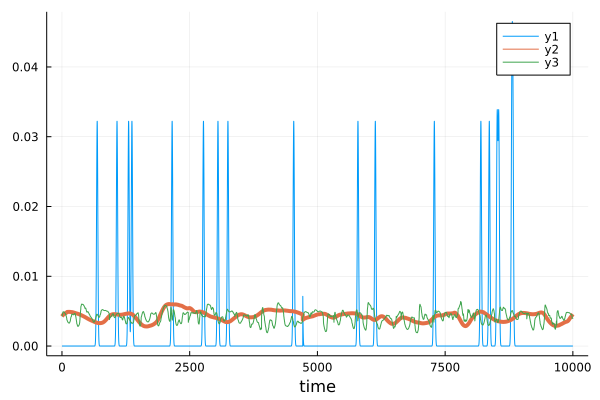

In [57]:
plot(; xlabel="time")
plot!(y[1:10000])
plot!(ŷ[1:10000]; lw=4)
plot!(predictions[1:10000, :ŷ])
